<h1><u> Exercise 1: Load shifting</u></h1>

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from ftplib import FTP

#### Data is downloaded from the FTP server supplied.

In [2]:
ftp = FTP('138.68.70.112')
ftp.login('student','tiipwi')
ftp.cwd('data/nordpoolspot.com/Elspot/Elspot_prices/Denmark/Denmark_West/')
ftp.retrbinary('RETR odedkk16.sdv', open('pricedata.sdv', 'wb').write)

'226 Transfer complete.'

#### Price data is opened and parsed, latest date is found and used to download corresponding CO2 file.

In [3]:
with open('odedkk16.sdv','rb') as f:
    lastFilled = 0
    for i,line in enumerate(f):
        if len(line)>100:
            lastData = line
            
pricedata = lastData.decode(encoding='UTF-8').split(';')
date = pricedata[0]
dayPrices = pricedata[1:26]
dayPrices.pop(3)
dayPrices = [float(i.replace(',','.')) for i in dayPrices]

In [4]:
date_ = date.split('.')
co2File = "20"+date_[2]+date_[1]+date_[0]
ftp.cwd('../../../../../energinet.dk/co2prognoser')
ftp.retrbinary('RETR '+ co2File +'_CO2prognose.txt', open('co2data.txt', 'wb').write)

'226 Transfer complete.'

In [5]:
co2data = []
with open('co2data.txt','rt') as f:
    for i,line in enumerate(f):
        if i==0:
            co2date = line
        if i>1:
            co2data.append(float(line.split(';')[1]))

### A visualization of the data:

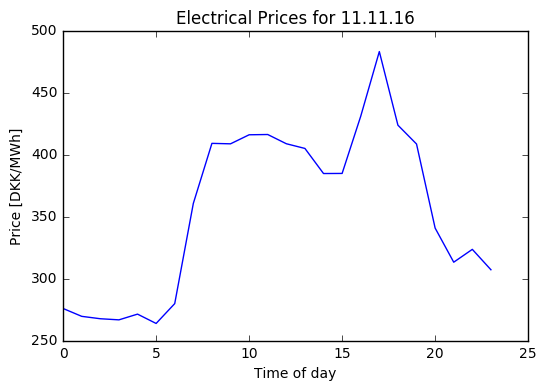

In [6]:
plt.title("Electrical Prices for " +date)
plt.plot(list(range(0,24)),dayPrices)
plt.xlabel("Time of day")
plt.ylabel("Price [DKK/MWh]")
plt.show()

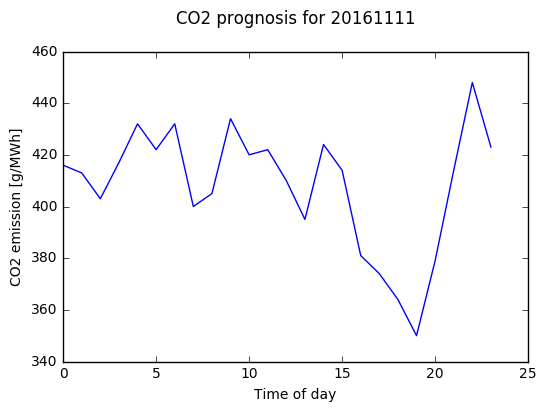

In [7]:
plt.title('CO2 prognosis for '+co2date)
plt.plot(co2data)
plt.xlabel('Time of day')
plt.ylabel('CO2 emission [g/MWh]')
plt.show()

## Toms Consumption Scenario

In [8]:
hours = np.arange(0,24)
minutes = np.arange(0,60,5)
times = list(itertools.product(hours,minutes))
timeIndices = list(range(0,len(times)))
timeList = [i*5/60 for i in timeIndices]

In [9]:
class Appliance:
    def __init__(self, name, startTime, applianceLoad,shiftable=False,curtailable=False):
        self.name = name
        self.time = startTime
        self.load = applianceLoad
        self.shiftable = shiftable
        self.curtailable = curtailable
        
        ind = times.index(startTime)
        self.indices = list(range(ind,ind+len(applianceLoad)))
        self.timing = [i*5/60 for i in self.indices]
    
    def price(self,dayPrices):
        _Load = np.zeros(24*12)
        _Load[self.indices] = self.load
        _Load = [float(sum(_Load[12*i:12*(i+1)])/12) for i in range(24)]
        return sum([_Load[i]*dayPrices[i]*10**(-6) for i in range(24)])

In [10]:
car = Appliance("Car",
                (18,0), 
                [3600]*18 + [3000] + [1000] + [300] + [100] + [50] + [10],
                shiftable=True, curtailable=True)
oven = Appliance("Oven",
                 (18,10),
                 [2250, 2350, 2200, 2000, 1300, 2000, 500, 500])
stove = Appliance("Stove",
                  (18,20),
                  [840]*6)
television = Appliance("Television",
                       (19,0),
                       [55]*9)
dryer = Appliance("Dryer",
                  (21,30),
                  [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1600, 1600, 1600, 1300, 1300, 1300, 940, 940, 940],
                  shiftable=True)
applianceList = [car,oven,stove,television,dryer]

#### We want an overview of what the effect of individual appliances is.

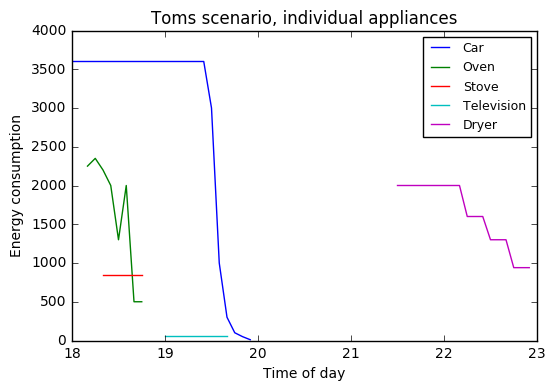

In [11]:
plt.title('Toms scenario, individual appliances')
for appliance in applianceList:
    plt.plot(appliance.timing,appliance.load,label=appliance.name)
plt.xlabel('Time of day')
plt.ylabel('Energy consumption')
plt.legend(prop={'size':9})
plt.show()

#### Luckily, we have shiftable appliances in the dryer and the car, two of the big contributers to the total power load. It is not possible to switch the others, as Tom is not particularly interested in waiting with food or entertainment.

In [12]:
def aggregateLoad(appliances):
    aggregatedLoad = np.zeros(len(timeList))

    for appliance in appliances:
        aggregatedLoad[appliance.indices] += appliance.load
        
    return aggregatedLoad

In [13]:
aggregatedLoad = aggregateLoad(applianceList)

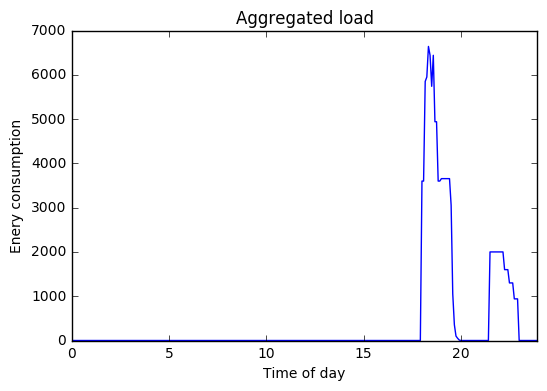

In [14]:
plt.title('Aggregated load')
plt.plot(timeList,aggregatedLoad)
plt.xlim(min(timeList),max(timeList))
plt.xlabel('Time of day')
plt.ylabel('Enery consumption')
plt.show()

#### So most of Tom's power consumption happen right after he gets home from work. Let us consider what prices he has to pay for this particular consumption. We calculate the watt-hours spent in each hour.

#### By multiplying the spend amount with the price for one watt-hour, the price for each hour is found. Then, the total price for the consumption of the day may be summed It the same way, the CO2 emission is found.

In [15]:
def calcPriceCO2(aggregatedLoad):
    aggregatedHourLoad = [float(sum(aggregatedLoad[12*i:12*(i+1)])/12) for i in range(24)]
    totalPrice = sum([aggregatedHourLoad[i]*dayPrices[i]*10**(-6) for i in range(24)])
    totalCO2 = sum([aggregatedHourLoad[i]*co2data[i]*10**(-6) for i in range(24)])
    return totalPrice, totalCO2

totalPrice,totalCO2 = calcPriceCO2(aggregatedLoad)
print("Toms consumption has a price of %.2f DKK and results in a CO2 emission of %.2f g" %(totalPrice, totalCO2))

Toms consumption has a price of 3.85 DKK and results in a CO2 emission of 3.70 g


## Optimizing the scenario

In [16]:
optimizedAppliances = []

for appliance in applianceList:
    if appliance.shiftable:
        print("Optimizing shiftable appliance: " + appliance.name)
        bestPrice = appliance.price(dayPrices)
        bestAppliance = appliance
        for time in times:
            if times.index(time) + len(appliance.load) < 24*12:
                newAppliance = Appliance(appliance.name,
                                         (time),
                                         appliance.load,
                                         appliance.shiftable,
                                         appliance.curtailable)
                newPrice = newAppliance.price(dayPrices)
                if newPrice < bestPrice:
                    bestPrice = newPrice
                    bestAppliance = newAppliance
        optimizedAppliances.append(bestAppliance)
    else:
        optimizedAppliances.append(appliance)

Optimizing shiftable appliance: Car
Optimizing shiftable appliance: Dryer


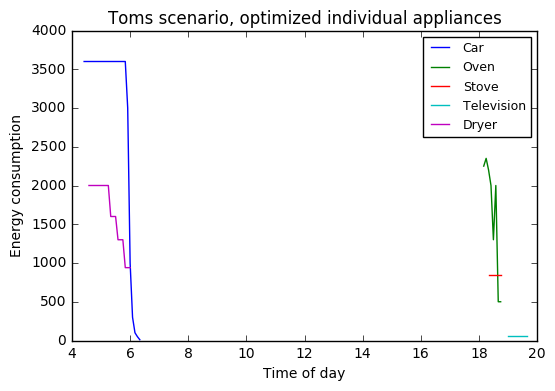

In [17]:
plt.title('Toms scenario, optimized individual appliances')
for appliance in optimizedAppliances:
    plt.plot(appliance.timing,appliance.load,label=appliance.name)
plt.xlabel('Time of day')
plt.ylabel('Energy consumption')
plt.legend(loc=1,prop={'size':9})
plt.show()

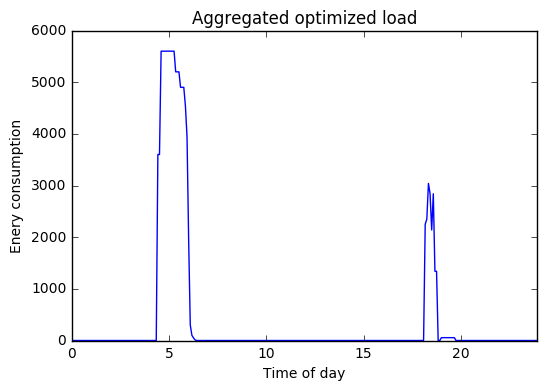

In [18]:
aggregatedOptimizedLoad = aggregateLoad(optimizedAppliances)

plt.title('Aggregated optimized load')
plt.plot(timeList,aggregatedOptimizedLoad)
plt.xlim(min(timeList),max(timeList))
plt.xlabel('Time of day')
plt.ylabel('Enery consumption')
plt.show()

In [19]:
totalPriceOpt,totalCO2Opt = calcPriceCO2(aggregatedOptimizedLoad)
print("Toms consumption has a price of %.2f DKK and results in a CO2 emission of %.2f g" %(totalPriceOpt, totalCO2Opt))
print("So Tom has saved %.2f DKK and experiences a change in CO2 emission of %.2f g" %(totalPrice-totalPriceOpt , totalCO2-totalCO2Opt))

Toms consumption has a price of 2.85 DKK and results in a CO2 emission of 4.07 g
So Tom has saved 1.00 DKK and experiences a change in CO2 emission of -0.37 g


#### There are several further things which could be considered. One thing is constraints such as ensuring that Toms car is charged when he has to leave in the morning. The optimization could be improved further by splitting splitable loads instead of one continous use. It could also be possible to optimize simultaneously for price and CO2 emission, to consider the tradeoff between the two, and possibly improve on both over the initial scenario. 